# Trabalho Final
## Astronomia Dinâmica
Thiago Laidler Vidal Cunha       1/2024

In [ ]:
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install pandas

 - Definindo classe *efeméride* criado por mim para facilitar a análise dos dados:

In [ ]:
from astroquery.vizier import Vizier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LogNorm
import scipy

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
import glob

import datetime as dt
from dateutil.relativedelta import relativedelta
from astroquery.jplhorizons import Horizons

def arcsegundos_para_graus(arcsegundos):
    """
    Converte um valor em arcsegundos para graus.

    Parâmetros:
    arcsegundos (float): O valor em arcsegundos a ser convertido.

    Retorna:
    float: O valor convertido em graus.
    """
    graus = arcsegundos / 3600.0
    return graus

class Efemeride:
    def __init__(self, name, start, end, step='d'):
        self.name = name
        self.start = start
        self.end = end
        self.step = step

    def datetime_to_epochs_days(self, dt, days=1):
        """
        Converte um objeto datetime em epochs compatíveis com o Astroquery.

        Parâmetros:
            dt (datetime): O objeto datetime a ser convertido.

        Retorna:
            epochs (dict): Um dicionário contendo as informações de epochs no formato
                           adequado para o Astroquery.
        """
        start = dt.strftime('%Y-%m-%d %H:%M:%S')

        end = (dt + relativedelta(days=days)).strftime('%Y-%m-%d %H:%M:%S')

        epochs = {'start': start, 'stop': end, 'step': '1' + self.step}

        return epochs

    def get_ephemerides_by_astropy(self, epoch=None):
        if epoch is None:
            obj = Horizons(id=self.name)
            eph = obj.ephemerides()
        else:
            obj = Horizons(id=self.name, epochs=epoch)
            eph = obj.ephemerides()
        return eph

    def fetch_ephemerides_dataframe(self):
        start = self.start.strftime('%Y-%m-%d %H:%M:%S')
        end = self.end.strftime('%Y-%m-%d %H:%M:%S')
        epochs = {'start': start, 'stop': end, 'step': '1' + self.step}
        eph = self.get_ephemerides_by_astropy(epoch=epochs)
        print(f"\nEfemérides de {self.name} para até {self.end.year} anos:")
        return eph

    def plot_RA_DEC(self):
        start = self.start.strftime('%Y-%m-%d %H:%M:%S')
        end = self.end.strftime('%Y-%m-%d %H:%M:%S')
        epochs = {'start': start, 'stop': end, 'step': '1' + self.step}
        eph = self.get_ephemerides_by_astropy(epoch=epochs)
        print(f"\nEfemérides de {self.name} para até {self.end.year} anos:")

        # Plot
        plt.figure(figsize=(12, 6))
        plt.subplot(211)
        plt.title(f"Evolução de RA com o tempo ({self.name})")
        plt.plot(eph['datetime_str'], eph['RA'], label='RA')
        plt.xlabel('Tempo')
        plt.ylabel('RA (graus)')
        plt.legend()

        plt.subplot(212)
        plt.title(f"Evolução de DEC com o tempo ({self.name})")
        plt.plot(eph['datetime_str'], eph['DEC'], label='DEC')
        plt.xlabel('Tempo')
        plt.ylabel('DEC (graus)')
        plt.legend()

        plt.tight_layout()
        plt.show()


O trabalho será composto por alguns estudos de caso:

> **1)** As sutilezas dos troianos de jupiter (pequena orbita em torno de um ponto), utilizando 588 Aquiles como modelo (também será feito uma tentativa de observar o movimento de Paris e Aquiles ao redor de L4 e L5).

> **2)** Tentativa de identificar satélite de Makemake a partir da diferença entre a precisão das medidas da efeméride e do Gaia

> **3)** Resolução do exercício 1.7.1 (programa para calcular as equações de Kepler)

### 1) Estudo sobre as sutilezas das órbitas dos troianos de Jupiter:

#Anotação, deletar depois:

Buscar pontos mais proximos -> tentar identificar forma de onda. Ver grandeza Gaia e JPL -> grau ou mac? Comparar dados makemake após 1 período -> tentar evitar variações 'ruido' -> tentar identificar satélite.

In [ ]:
efem = Efemeride(name='Achilles', start = dt.datetime(2010, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df = efem.fetch_ephemerides_dataframe().to_pandas()
df['datetime'] = pd.to_datetime(df['datetime_str']) #passando a informação das datas para datetime (facilita o plot)


Efemérides de Achilles para até 2024 anos:


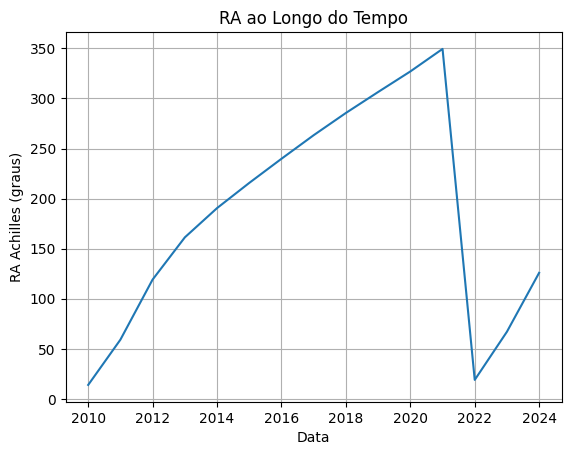

In [ ]:
# Gráfico da ascenção reta Achilles em graus
plt.figure()
plt.plot(df['datetime'], df['RA'])
plt.xlabel('Data')
plt.ylabel('RA Achilles (graus)')
plt.title('RA ao Longo do Tempo')
plt.grid(True)
plt.show()

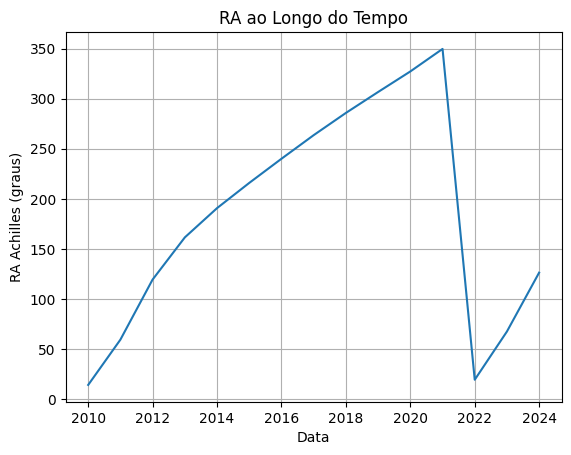

In [ ]:
# Gráfico da ascenção reta Achilles em graus
plt.figure()
plt.plot(df['datetime'], df['RA_app'])
plt.xlabel('Data')
plt.ylabel('RA Achilles (graus)')
plt.title('RA ao Longo do Tempo')
plt.grid(True)
plt.show()

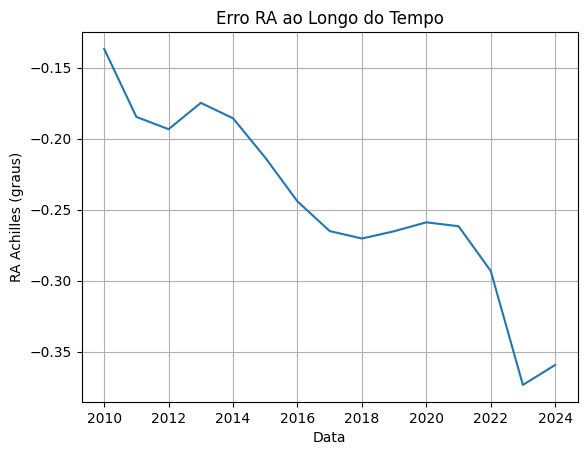

In [ ]:
# Gráfico da diferença entre ascenção reta astrométrica e aparente de Achilles em graus
plt.figure()
plt.plot(df['datetime'], (df['RA']-df['RA_app']))
plt.xlabel('Data')
plt.ylabel('RA Achilles (graus)')
plt.title('Erro RA ao Longo do Tempo')
plt.grid(True)
plt.show()

### Efeitos Considerados na Diferença

- Atraso de Tempo de Luz (Light-Time Delay):

RA (ICRF) já é compensado pelo atraso de tempo de luz (tempo que a luz leva para viajar do alvo até o observador).
RA (apparent) também considera o atraso de tempo de luz, mas aplicado ao instante de observação.

- Deflexão Gravitacional da Luz:

RA (apparent) inclui correções para a deflexão da luz causada pelo campo gravitacional do Sol e outros corpos.

- Aberração Estelar:

Movimento da Terra ao redor do Sol causa um desvio aparente na posição das estrelas.
RA (apparent) inclui este efeito.

- Precessão e Nutação:

RA (apparent) é ajustada para a precessão (movimento lento do eixo de rotação da Terra) e nutação (pequenas oscilações periódicas no eixo de rotação).
Paralaxe

RA (apparent) pode incluir efeitos de paralaxe (deslocamento aparente devido ao movimento da Terra ao redor do Sol).

A diferença entre RA e RA_app pode indicar o nível de correções necessárias para obter a posição aparente real do alvo. Além disso, essa diferença pode quantificar como a precessão e nutação afetam a posição do alvo.

 - Tentativa de graficar a libração entre Achilles e Paris e identificar os pontos de Lagrange:

In [ ]:
#Achilles
efem_A = Efemeride(name='Achilles', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_A = efem_A.fetch_ephemerides_dataframe().to_pandas()
df_A['datetime'] = pd.to_datetime(df_A['datetime_str']) #passando a informação das datas para datetime (facilita o plot)

#Paris
efem_P = Efemeride(name='Paris', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_P = efem_P.fetch_ephemerides_dataframe().to_pandas()
df_P['datetime'] = pd.to_datetime(df_P['datetime_str']) #passando a informação das datas para datetime (facilita o plot)


#Jupiter
efem_J = Efemeride(name='Jupiter Barycenter', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_J = efem_J.fetch_ephemerides_dataframe().to_pandas()
df_J['datetime'] = pd.to_datetime(df_J['datetime_str'])


Efemérides de Achilles para até 2024 anos:

Efemérides de Paris para até 2024 anos:

Efemérides de Jupiter Barycenter para até 2024 anos:


In [ ]:
# Função para quebrar a continuidade dos ângulos
def ajustar_continuidade(angles):
    adjusted_angles = []
    offset = 0
    for i in range(len(angles)):
        if i > 0 and angles[i] < angles[i - 1]:
            offset += 360
        adjusted_angles.append(angles[i] + offset)
    return adjusted_angles

df_A['adjusted_RA'] = ajustar_continuidade(df_A['RA'])
df_A['adjusted_DEC'] = ajustar_continuidade(df_A['DEC'])

df_P['adjusted_RA'] = ajustar_continuidade(df_P['RA'])
df_P['adjusted_DEC'] = ajustar_continuidade(df_P['DEC'])

df_J['adjusted_RA'] = ajustar_continuidade(df_J['RA'])
df_J['adjusted_DEC'] = ajustar_continuidade(df_J['DEC'])

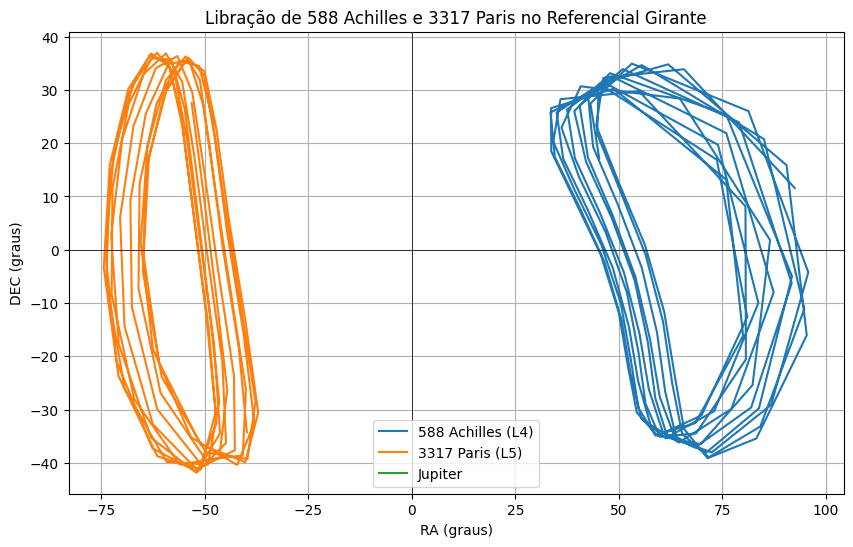

In [ ]:
# Plotar a libração no referencial girante
plt.figure(figsize=(10, 6))
plt.plot(df_A['adjusted_RA'] - df_J['adjusted_RA'], df_A['DEC'] - df_J['DEC'], label='588 Achilles (L4)')
plt.plot(df_P['adjusted_RA'] - df_J['adjusted_RA'], df_P['DEC']- df_J['DEC'], label='3317 Paris (L5)')
plt.plot(df_J['adjusted_RA'] - df_J['adjusted_RA'], df_J['DEC']- df_J['DEC'], label='Jupiter')
plt.xlabel('RA (graus)')
plt.ylabel('DEC (graus)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Libração de 588 Achilles e 3317 Paris no Referencial Girante')
plt.legend()
plt.grid(True)
plt.show()

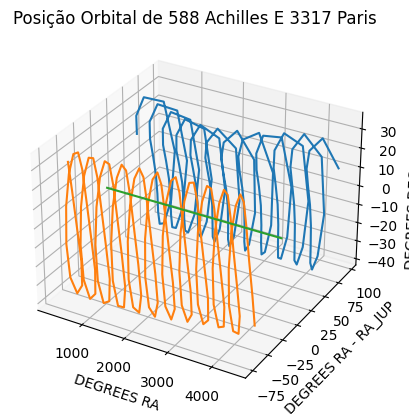

In [ ]:
# Gráfico da Posição Orbital (x, y, z) ao Longo do Tempo
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_A['adjusted_RA'], df_A['adjusted_RA'] - df_J['adjusted_RA'],  df_A['DEC'] - df_J['DEC'])
ax.plot(df_P['adjusted_RA'], df_P['adjusted_RA'] - df_J['adjusted_RA'], df_P['DEC']- df_J['DEC'])
ax.plot(df_J['adjusted_RA'], df_J['adjusted_RA'] - df_J['adjusted_RA'], df_J['DEC']- df_J['DEC'])
ax.set_xlabel('DEGREES RA')
ax.set_ylabel('DEGREES RA - RA_JUP')
ax.set_zlabel('DEGREES DEC - DEC_JUP')
ax.set_title('Posição Orbital de 588 Achilles E 3317 Paris')
plt.show()

 - Tentando fazer o mesmo para troianos de Netuno:

 >2001 QR322 L4

 >2008 LC18 L5

In [ ]:
#QR322
efem_1 = Efemeride(name='2001 QR322', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_1 = efem_1.fetch_ephemerides_dataframe().to_pandas()
df_1['datetime'] = pd.to_datetime(df_1['datetime_str']) #passando a informação das datas para datetime (facilita o plot)

#LC18
efem_2 = Efemeride(name='2008 LC18', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_2 = efem_2.fetch_ephemerides_dataframe().to_pandas()
df_2['datetime'] = pd.to_datetime(df_2['datetime_str']) #passando a informação das datas para datetime (facilita o plot)


#Netuno
efem_N = Efemeride(name='Neptune Barycenter', start = dt.datetime(1890, 1, 1, 1, 0), end = dt.datetime(2024, 1, 1, 1, 0), step = 'y')
df_N = efem_N.fetch_ephemerides_dataframe().to_pandas()
df_N['datetime'] = pd.to_datetime(df_N['datetime_str'])


#Normalizando RA/DEC

df_1['adjusted_RA'] = ajustar_continuidade(df_1['RA'])

df_2['adjusted_RA'] = ajustar_continuidade(df_2['RA'])

df_N['adjusted_RA'] = ajustar_continuidade(df_N['RA'])


Efemérides de 2001 QR322 para até 2024 anos:

Efemérides de 2008 LC18 para até 2024 anos:

Efemérides de Neptune Barycenter para até 2024 anos:


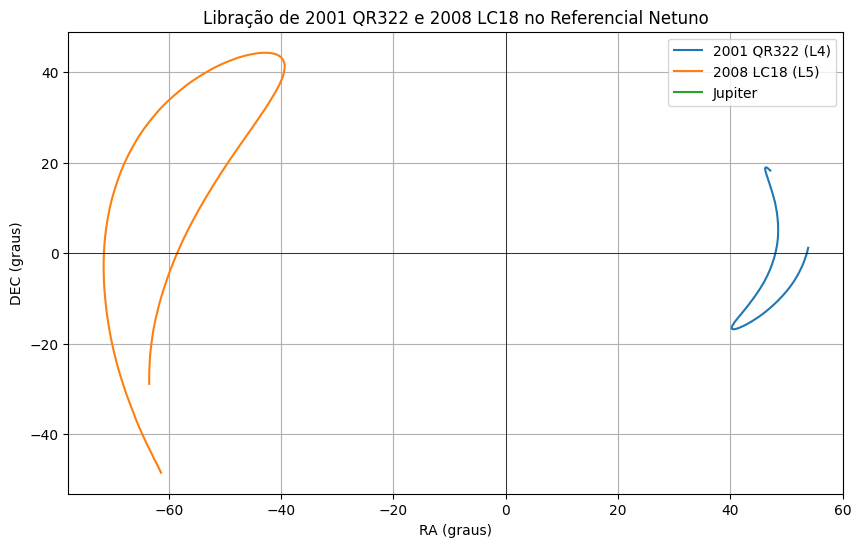

In [ ]:
# Plotar a libração no referencial Netuno
plt.figure(figsize=(10, 6))
plt.plot(df_1['adjusted_RA'] - df_N['adjusted_RA'], df_1['DEC'] - df_N['DEC'], label='2001 QR322 (L4)')
plt.plot(df_2['adjusted_RA'] - df_N['adjusted_RA'], df_2['DEC']- df_N['DEC'], label='2008 LC18 (L5)')
plt.plot(df_N['adjusted_RA'] - df_N['adjusted_RA'], df_N['DEC']- df_N['DEC'], label='Jupiter')
plt.xlabel('RA (graus)')
plt.ylabel('DEC (graus)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Libração de 2001 QR322 e 2008 LC18 no Referencial Netuno')
plt.legend()
plt.grid(True)
plt.show()

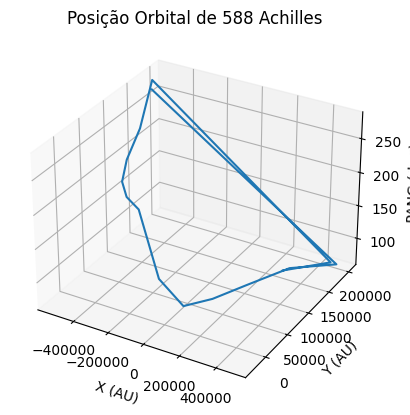

In [ ]:
#curiosidade
# Gráfico da Posição como Satélite (x, y, z) ao Longo do Tempo
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df['sat_X'], df['sat_Y'], df['sat_PANG'])
ax.set_xlabel('ARCSECONDS')
ax.set_ylabel('ARCSECONDS')
ax.set_zlabel('DEGREES')
ax.set_title('Posição Orbital de 588 Achilles')
plt.show()

### 2) Tentativa de detectar órbita binaria entre Makemake e seu satélite.

>**Makemake** é o segundo *planeta anão* mais afastado do Sol, com um semieixo maior médio de 45,790 UA. Atualmente, está a uma distância de 52,5 UA do Sol, quase atingindo seu afélio (53,073 UA), o que acontecerá em 2033.  
>
>Sua órbita é parecida à de Haumea, com uma alta inclinação de 29° e excentricidade moderada de 0,16°, mas é mais afastada do Sol em termos de semieixo maior, perélio e afélio. O período orbital de **Makemake** é de aproximadamente 310 anos, maior que o de Plutão (248 anos) e Haumea (284 anos).  

In [ ]:
df_gaia = pd.read_csv('Gaia_Makemake.csv', sep=';', comment='#', #na_values=' '
                   )
df_gaia = df_gaia.dropna(axis = 1)
df_gaia = df_gaia.drop(columns = ['_RAJ2000','_DEJ2000','SolID','Source','MPC','FG'])

In [ ]:
from astropy.time import Time
t = Time(2455197.5 + 2315.311 #epoch média
         , format='jd')
#t.iso , t.byear, t.jd...
print('A data média dos dados do GaiaDR3: ', t.iso)
tm = Time(2455197.5+2511.095 #epoch 50%
          , format='jd')
print('A data mediana dos dados do GaiaDR3: ',tm.iso)

A data média dos dados do GaiaDR3:  2016-05-04 07:27:50.400
A data mediana dos dados do GaiaDR3:  2016-11-16 02:16:48.000


In [ ]:
datetime_str = []
for i in range(len(df_gaia['Epoch'])):
    datetime_str.append((Time(df_gaia['Epoch'].loc[i] + 2455197.5, format = 'jd')).iso)

df_gaia['Datetime_str'] = datetime_str
#Organizando por data
df_gaia = df_gaia.sort_values(by=['Epoch']
                  #, ascending=False para organizar de ordem decrescente
                 )


# Criando uma coluna de datas Julian para fazer a busca das efemérides no JPL a partir dessas datas:
df_gaia['JD'] = df_gaia['Epoch'] + 2455197.5
jd = []
for i in range(len(df_gaia['Epoch'])):
    jd.append(round(df_gaia['Epoch'][i],5) + 2455197.5 )


from astroquery.jplhorizons import Horizons

obj = Horizons(id='MakeMake', #location='568',
               epochs=jd)

eph = obj.ephemerides()
#Passando pra data frame
df_EF = eph.to_pandas() # Data Frame da Efemeride pega pelo query com base nos tempos do Gaia
#dropar todas as colunas que não sejam importantes para nossa análise.
df_EF = df_EF.drop(columns = ['solar_presence',#'flags',
                                  'AZ','EL','AZ_rate','EL_rate','sat_X','sat_Y','sat_PANG','airmass','magextinct',
                                  'surfbright','illumination','illum_defect',
                                  'sat_sep','sat_vis','ang_width',
       'PDObsLon', 'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang',
       'SubSol_dist', 'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r',
       'r_rate', 'delta', 'delta_rate', 'lighttime', 'vel_sun', 'vel_obs',
       'elong', 'elongFlag', 'alpha', 'lunar_elong', 'lunar_illum',
       'sat_alpha', 'sunTargetPA', 'velocityPA', 'OrbPlaneAng',
       'constellation', 'TDB-UT', 'ObsEclLon', 'ObsEclLat', 'NPole_RA',
       'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime', 'earth_lighttime',
       'SMAA_3sigma', 'SMIA_3sigma', 'Theta_3sigma',
       'Area_3sigma', 'RSS_3sigma', 'r_3sigma', 'r_rate_3sigma',
       'SBand_3sigma', 'XBand_3sigma', 'DoppDelay_3sigma', 'true_anom',
       'hour_angle', 'alpha_true', 'PABLon', 'PABLat','siderealtime'])

  Plotando RA_ef - RA_gaia; DEC_ef - DEC_gaia a fim de identificar um possivel satélite do planeta anão.

  > Sistemas binarios possuem um plot ondulatório, já que a medida do gaia é precisa a ponto de identificar esse comportamento.

Para que esse plot seja possível, teremos que somar 2455197.5 a todos os valores de Epoch do gaia (df_vi) (isso já foi feito, está na variável jd).

No entanto, resta arredondar os valores após certa casa decimal. E deveremos arredondar da mesma forma para as efemérides. Isso pois há uma leve diferença entre os tempos do gaia e das efemérides, de forma que o computador não identifica-os como sendo os mesmos pontos. Portanto, a fim de termos uma array com os tempos corretos para o plot (50 elementos no eixo x para 50 elementos no eixo y), irei criar essa array de forma arredondada - o numero de casas decimais escolhida passou pelos devidos testes, escolhi aquela necessária para que a primeira linha de um catalogo fosse igual a primeira ligua do segundo, e assim por diante (e de forma independentente, de forma que a primeira linha de um catalogo não fosse igual a primeira E a segunda linha do segundo).

In [ ]:
RA_ef = df_EF['RA']
RA_gaia = df_gaia['RA_ICRS']

DEC_ef = df_EF['DEC']
DEC_gaia = df_gaia['DE_ICRS']

tempo = [] #julian date arredondado
for i in range(len(jd)):
    tempo.append(round(jd[i],5))
tempo.sort()

#### Conferindo se os pontos da lista 'tempo' coincide com as informações dos data frames na ordem correta.
#RA_gaia -> 193.015229 (1) 2014-11-05 22:23:46.061
#RA_ef ->   193.00808  (1) 2014-Nov-05 22:23:45.888
#tempo -> 2456967.43317 -> 1769.933172 + 2455197.5 = 2456967.433172
### Bate... então teoricamente o plot deveria estar correto...

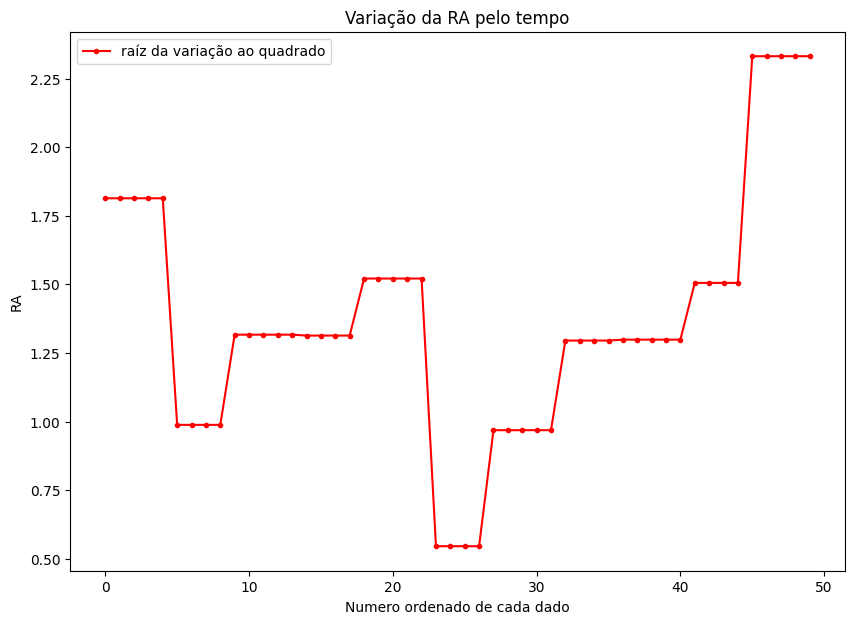

In [ ]:
plt.figure(figsize = [10,7])
plt.title('Variação da RA pelo tempo')
plt.plot(list(range(50)),np.sqrt((RA_gaia - RA_ef)**2), 'r.-')
plt.legend(['raíz da variação ao quadrado'])
plt.xlabel('Numero ordenado de cada dado')
#plt.xlabel('Tempo em Data Juliana -  a partir de 2000')
plt.ylabel('RA')
plt.show()

A falta de dados entre estas observações compromete a visualização da onda mais formalizada.


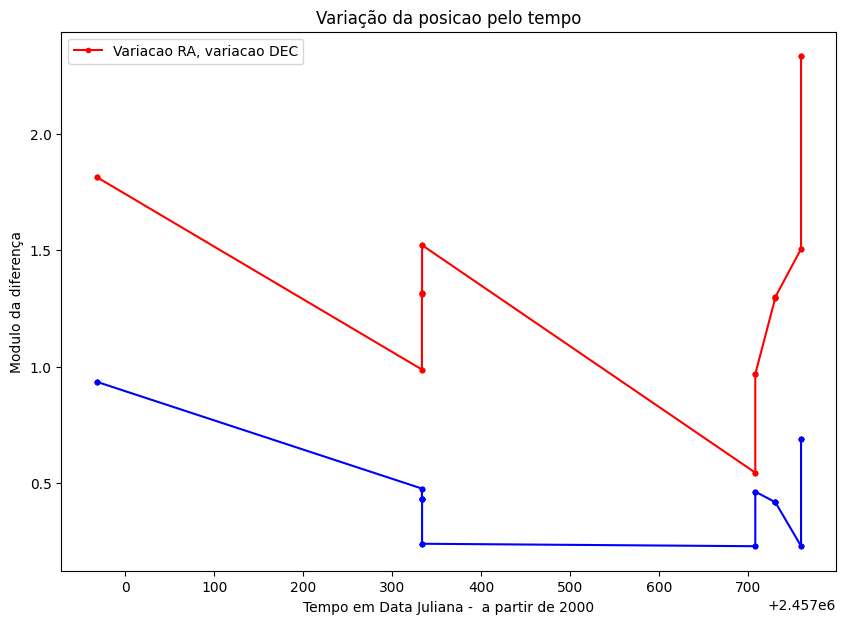

In [ ]:
plt.figure(figsize = [10,7])
plt.title('Variação da posicao pelo tempo')
plt.plot(tempo,np.sqrt((RA_gaia - RA_ef)**2), 'r.-')
plt.plot(tempo,np.sqrt((DEC_ef - DEC_gaia)**2),'b.-')
plt.legend(['Variacao RA, variacao DEC'])
plt.xlabel('Tempo em Data Juliana -  a partir de 2000')
plt.ylabel('Modulo da diferença')
print("A falta de dados entre estas observações compromete a visualização da onda mais formalizada.")
plt.show()

### 3) Exercício 1.7

As imagens a seguir mostram como a anomalia excêntrica muda com a anomalia média para diferentes valores de excentricidade orbital. Dá para ver que, quando a excentricidade é baixa, os dois ângulos se comportam de maneira linear. Mas, quando a excentricidade aumenta, a curva começa a ter uma leve curvatura. Isso quer dizer que, para anomalias médias perto de 180 graus, a anomalia excêntrica cresce mais devagar comparado com as anomalias médias perto de 0 ou 340 graus.

A velocidade com que a Equação de Kepler converge está relacionada ao número de passos necessários no método numérico para atingir a precisão desejada. Então, foram feitos gráficos mostrando a quantidade de passos necessários para calcular a anomalia excêntrica para cada valor de anomalia média. Esses gráficos mostram que o método geralmente converge mais rápido perto dos ângulos de 0 e 180 graus. Também é possível ver que, para ângulos entre 0 e 180, ou entre 180 e 340 graus, quanto maior a excentricidade orbital, maior é o número de passos necessários para calcular a anomalia excêntrica. Ou seja, o método converge mais devagar quanto maior for a excentricidade.

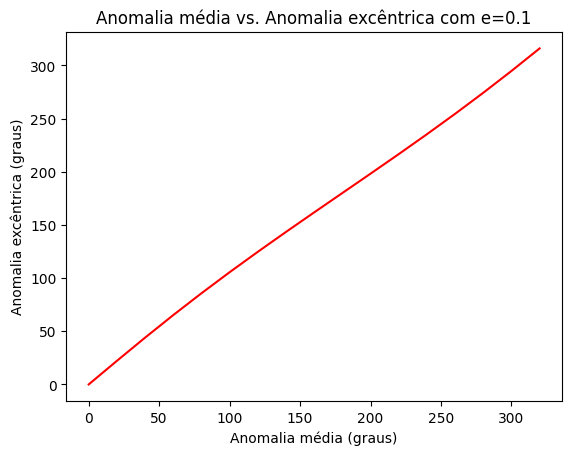

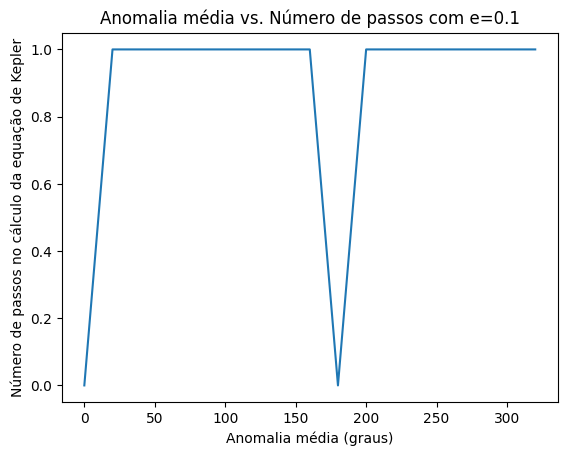

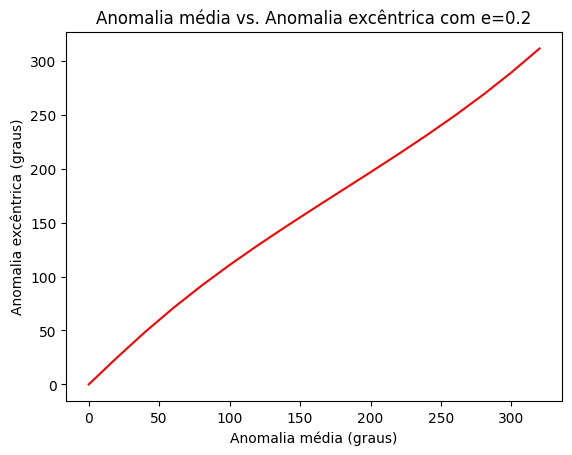

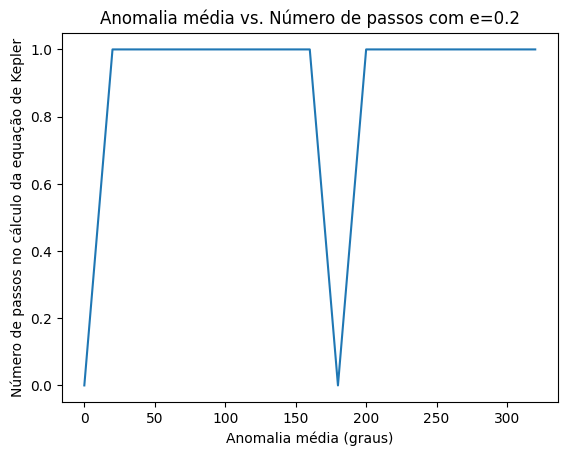

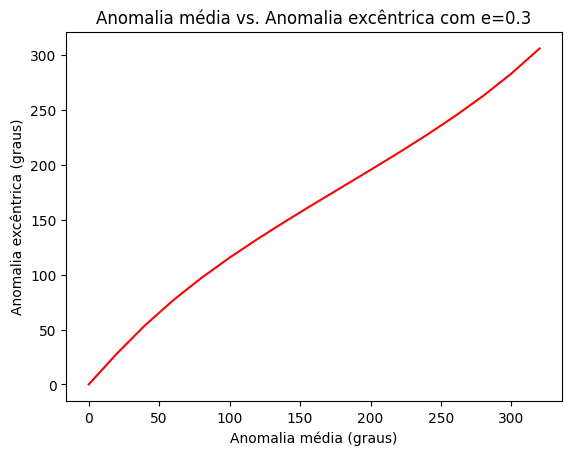

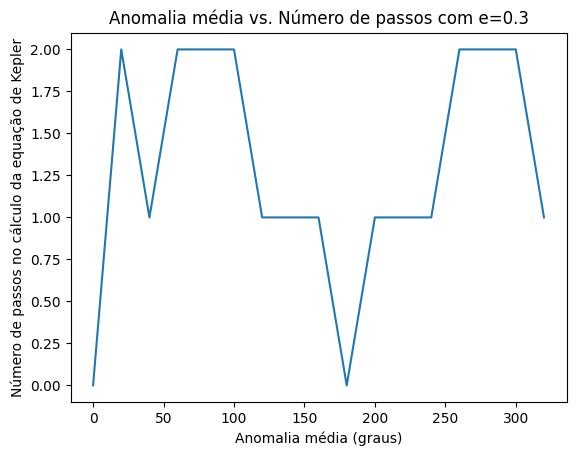

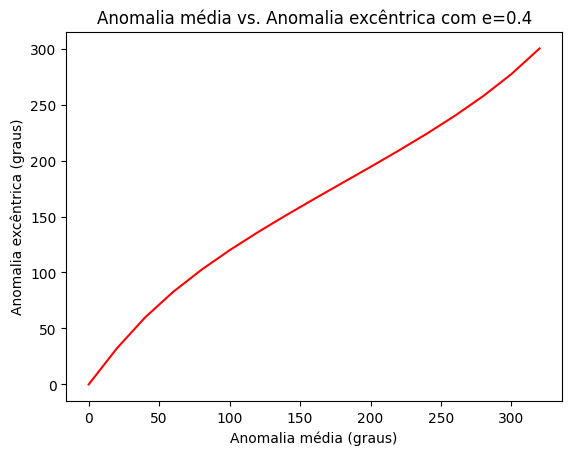

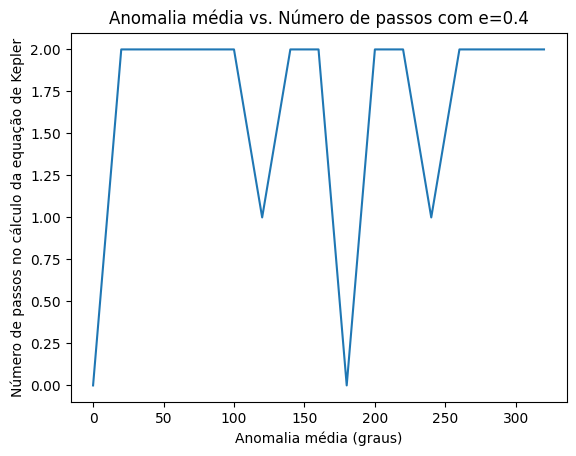

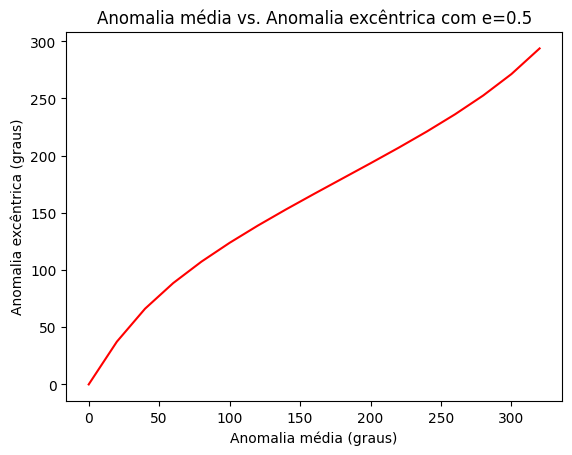

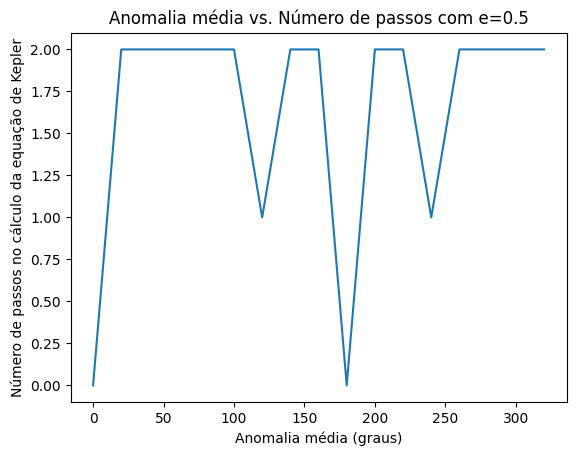

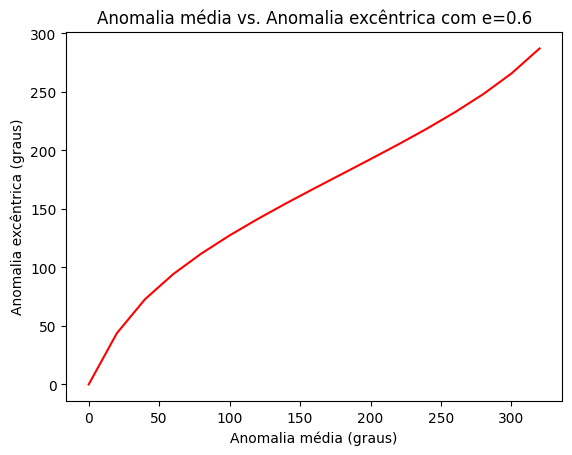

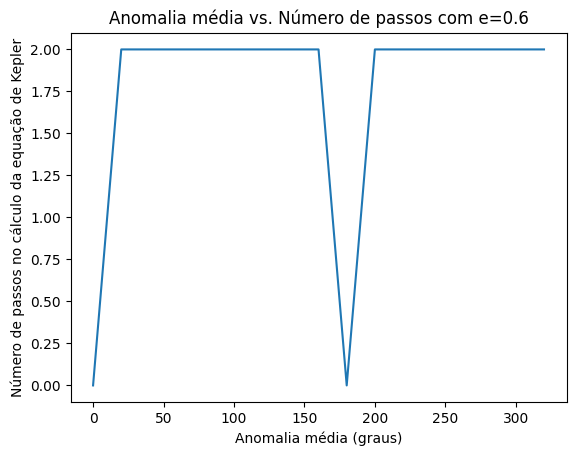

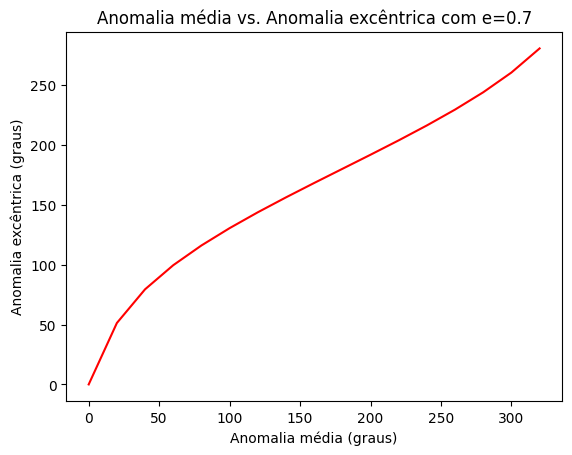

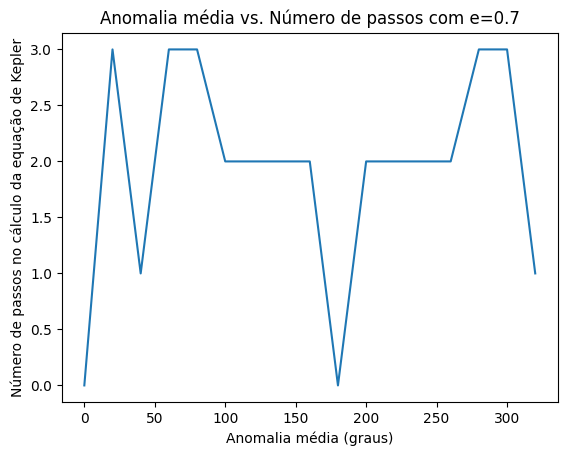

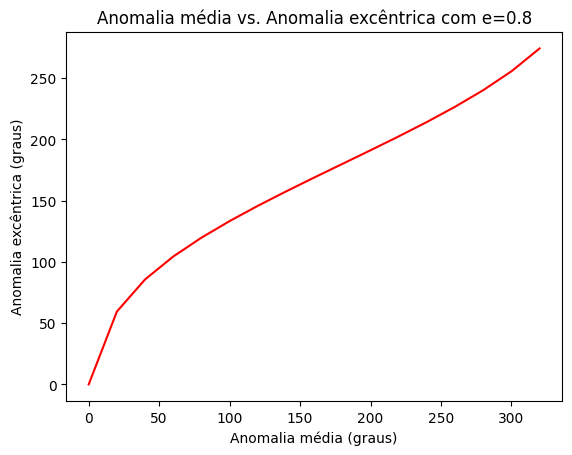

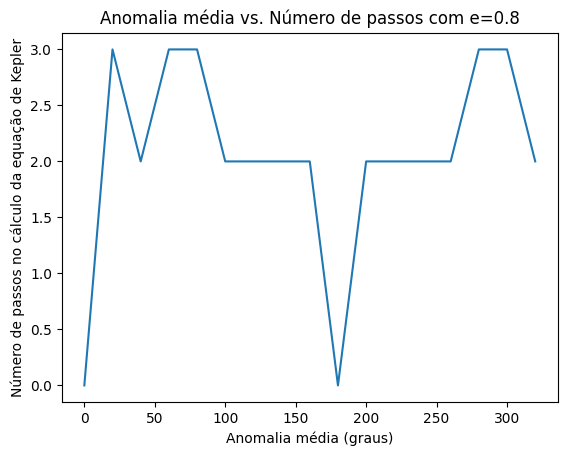

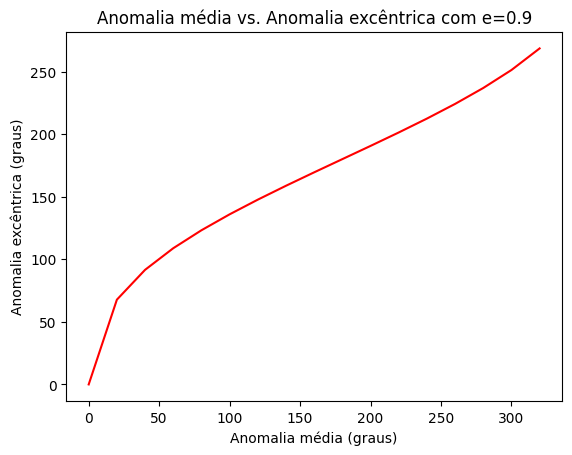

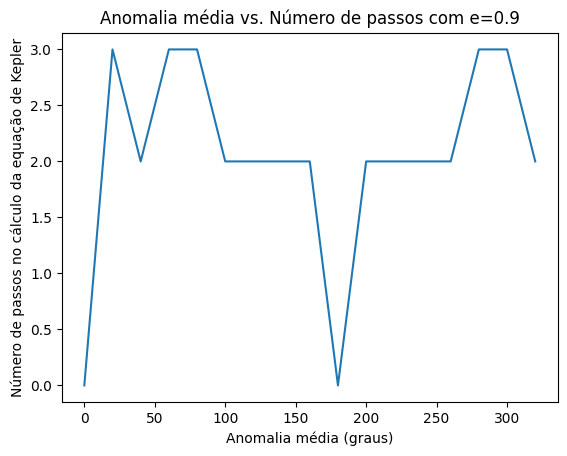

In [ ]:
def funcG(e, u):
    return u - e * np.sin(u)

def funcGpt(e, u):
    return 1 - e * np.cos(u)

def Eq_Kepler(i, e):
    uo = i + e * np.sin(i) + (1 / 2) * (e ** 2) * np.sin(2 * i)
    io = funcG(e, uo)
    erro = 1 / 60 / 60 * np.pi / 180
    passos = 0

    while np.abs(i - io) > erro:
        b = io - funcGpt(e, uo) * uo
        u1 = (i - b) / funcGpt(e, uo)
        io = funcG(e, u1)
        uo = u1
        passos += 1

    return uo, passos

excentricidades = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for e in excentricidades:
    anomalias_media = np.arange(0, 340 * np.pi / 180, 20 * np.pi / 180)
    anomalias_excentrica = []
    passos_calculo = []

    for i in anomalias_media:
        ul, passos = Eq_Kepler(i, e)
        anomalias_excentrica.append(ul * 180 / np.pi)
        passos_calculo.append(passos)

    anomalias_media_graus = anomalias_media * 180 / np.pi

    # Plotando anomalia média vs anomalia excêntrica
    plt.plot(anomalias_media_graus, anomalias_excentrica, 'r')
    plt.xlabel('Anomalia média (graus)')
    plt.ylabel('Anomalia excêntrica (graus)')
    plt.title(f'Anomalia média vs. Anomalia excêntrica com e={e}')
    plt.show()

    # Plotando anomalia média vs número de passos
    plt.plot(anomalias_media_graus, passos_calculo)
    plt.xlabel('Anomalia média (graus)')
    plt.ylabel('Número de passos no cálculo da equação de Kepler')
    plt.title(f'Anomalia média vs. Número de passos com e={e}')
    plt.show()
